In [1]:
import numpy as np
import pandas as pd

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import activations
from keras import metrics
import math

import random

# to make the experimens replicable
random.seed(123456)

Using TensorFlow backend.


In [2]:
df = pd.read_pickle('regione-toscana/atti-dirigenti.pkl')

In [3]:
dataset = df[['OGGETTO', 'UFFICIO_DG']]

In [4]:
dataset.head()

,OGGETTO,UFFICIO_DG
0,DGR 968/07 e s.m.i. Accreditamento degli organ...,50125
1,REG. CEE 2080/92 - AIUTI ALLE MISURE FORESTALI...,50117
2,"Servizi autorizzati ex art.14 L.R. 42/98 ""Norm...",50121
3,"L.R. 1/2006, DCR 3/2012, L.R. 1/2015 art.29, c...",50117
4,L.R. n. 87/1997 - Pubblicazione sul BURT dell'...,50116


In [5]:
dataset.shape

(153206, 2)

### Compute the number of classes

In [6]:
len(set(dataset.UFFICIO_DG))

43

### Groups the documents by office

In [7]:
documents_per_office = dataset.groupby(['UFFICIO_DG']).count()
documents_per_office.describe()

,OGGETTO
count,43.000000
mean,3562.930233
std,3408.012746
min,106.000000
25%,1020.000000
50%,2153.000000
75%,5418.000000
max,13890.000000


### We select the documents with frequency greater that the 25 percentile

In [8]:
value = documents_per_office.quantile(0.25)[0]
sel_dataset = documents_per_office[documents_per_office.OGGETTO >= value]
sel_dataset.shape

(32, 1)

In [9]:
sel_dataset['UFFICIO_DG'] = sel_dataset.index

/home/fabio/miniconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### Join the dataset to select a subset of the data

In [10]:
final_ds = dataset.merge(sel_dataset, how='inner', on=['UFFICIO_DG'])

In [11]:
final_ds.shape

(147463, 3)

In [12]:
dataset.shape

(153206, 2)

In [13]:
final_ds.head()

,OGGETTO_x,UFFICIO_DG,OGGETTO_y
0,DGR 968/07 e s.m.i. Accreditamento degli organ...,50125,4281
1,Nomina Commissione d’esame per il percorso for...,50125,4281
2,Nomina della Commissione d'esame matricola 201...,50125,4281
3,Progetti formativi per drop-out a.s.f. 2015-20...,50125,4281
4,REG (CE) 1080/2006-Por Creo Fesr 2007-2013-Lin...,50125,4281


### Select the OGGETTO and UFFICIO

In [14]:
final_ds = final_ds[['OGGETTO_x',"UFFICIO_DG"]]

In [15]:
final_ds.head()

,OGGETTO_x,UFFICIO_DG
0,DGR 968/07 e s.m.i. Accreditamento degli organ...,50125
1,Nomina Commissione d’esame per il percorso for...,50125
2,Nomina della Commissione d'esame matricola 201...,50125
3,Progetti formativi per drop-out a.s.f. 2015-20...,50125
4,REG (CE) 1080/2006-Por Creo Fesr 2007-2013-Lin...,50125


### Transform it in a dataset

In [16]:
samples = []
labels = []

In [17]:
for text, label in final_ds.as_matrix():
    samples.append(text)
    labels.append(label)

In [18]:
samples[:5]

["DGR 968/07 e s.m.i. Accreditamento degli organismi formativi. Rilascio dell'accreditamento all'organismo formativo Bioscience Research Center - cod. GR1035.",
 'Nomina Commissione d’esame per il percorso formativo “Formazione obbligatoria per utilizzatori professionali di prodotti fitosanitari”, MATRICOLA N. 2016SI0046',
 "Nomina della Commissione d'esame matricola 2016PI0301. Agenzia Formativa Cescot",
 'Progetti formativi per drop-out a.s.f. 2015-2016. Integrazione impegno per progetto "Figaro - Operatore del benessere (acconciatura)"',
 'REG (CE) 1080/2006-Por Creo Fesr 2007-2013-Linea di intevento 5.1.d-Chiusura attività']

In [19]:
labels[:5]

['50125', '50125', '50125', '50125', '50125']

In [20]:
samples = np.array(samples)
labels = np.array(labels)

## Train, Val and Test Set

Normally we split the dataset into:
- 70% for training
- 10% for validation
- 20% for testing

In [21]:
samples.shape

(147463,)

### Shuffle Data

In [22]:
indices = list(range(len(samples)))
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

In [23]:
labels[:5]

array(['50003', '01928', '50073', '50005', '50000'], dtype='<U5')

## Tokenize the Dataset

In [24]:
from keras.preprocessing.text import Tokenizer

In [25]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(samples)

In [26]:
sequences = tokenizer.texts_to_sequences(samples)

In [27]:
[print(s) for s in sequences[:2]]

[7, 6, 257, 263, 520, 105, 515, 46, 82, 27, 729, 770, 1, 35, 698, 2]
[37, 4481, 15, 2, 20, 1, 417, 8, 603, 1235, 1, 351, 50, 576, 3, 4481]


[None, None]

Convert labels to sequences

In [28]:
index_to_labels = dict(enumerate(set(labels)))
labels_to_index = {v:k for k,v in index_to_labels.items()}

In [29]:
labels_to_index

{'01025': 23,
 '01027': 6,
 '01923': 11,
 '01928': 30,
 '01931': 8,
 '01934': 31,
 '01937': 27,
 '01943': 19,
 '01946': 28,
 '02090': 13,
 '50000': 14,
 '50001': 20,
 '50002': 5,
 '50003': 26,
 '50004': 3,
 '50005': 18,
 '50006': 24,
 '50007': 4,
 '50069': 29,
 '50073': 7,
 '50079': 16,
 '50083': 12,
 '50102': 0,
 '50115': 2,
 '50116': 1,
 '50117': 15,
 '50118': 9,
 '50119': 22,
 '50123': 10,
 '50125': 25,
 '50127': 17,
 '50202': 21}

In [30]:
len(labels_to_index)

32

In [31]:
labels

array(['50003', '01928', '50073', ..., '50000', '01937', '50202'],
      dtype='<U5')

In [32]:
encoded_labels = [labels_to_index[l] for l in labels]

In [33]:
encoded_labels[:10]

[26, 30, 7, 18, 14, 16, 9, 7, 23, 10]

## Train, Val and Test Set

Normally, we split the dataset into:
- train: 70%
- val: 10%
- test: 20%

In [34]:
training_size = math.trunc(len(sequences) * 0.7)
val_size = math.trunc(len(sequences) * 0.8)
test_size = len(sequences)

In [35]:
train_data = sequences[:training_size]
train_labels = encoded_labels[:training_size]

val_data = sequences[training_size:val_size]
val_labels = encoded_labels[training_size:val_size]

test_data = sequences[val_size:]
test_labels = encoded_labels[val_size:] 

### Preparing Data

for data and labels

In [36]:
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension), dtype=np.float32)
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [37]:
x_train = vectorize_sequences(train_data)
x_val = vectorize_sequences(val_data)
x_test = vectorize_sequences(test_data)

In [38]:
x_train.shape

(103224, 10000)

One hot encoding for the labels

In [39]:
def to_one_hot(labels):
    results = np.zeros((len(labels), len(set(labels))), dtype=np.float32)
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

In [40]:
y_train = to_one_hot(train_labels)
y_val = to_one_hot(val_labels)
y_test = to_one_hot(test_labels)

## Build the Models

In [43]:
def build_model(neurons):
    model = models.Sequential()
    model.add(layers.Dense(neurons, activation='relu', input_shape=(x_train.shape[-1], )))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(neurons, activation='relu'))
    model.add(layers.Dense(len(labels_to_index), activation='softmax'))
    
    model.compile(optimizer=optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [44]:
model_small = build_model(16)
model_medium = build_model(64)
model_large = build_model(256)

In [45]:
history_small = model_small.fit(x=x_train, y=y_train, validation_data=(x_val,y_val),
                   epochs=10, batch_size=128)

Train on 103224 samples, validate on 14746 samples
Epoch 1/10
103224/103224 [==============================] - 6s 54us/step - loss: 1.6362 - acc: 0.5330 - val_loss: 1.0188 - val_acc: 0.6788
Epoch 2/10
103224/103224 [==============================] - 4s 42us/step - loss: 0.8304 - acc: 0.7325 - val_loss: 0.8575 - val_acc: 0.7226
Epoch 3/10
103224/103224 [==============================] - 4s 40us/step - loss: 0.6718 - acc: 0.7769 - val_loss: 0.8051 - val_acc: 0.7390
Epoch 4/10
103224/103224 [==============================] - 4s 42us/step - loss: 0.5893 - acc: 0.8015 - val_loss: 0.7923 - val_acc: 0.7439
Epoch 5/10
103224/103224 [==============================] - 4s 42us/step - loss: 0.5348 - acc: 0.8175 - val_loss: 0.7991 - val_acc: 0.7462
Epoch 6/10
103224/103224 [==============================] - 4s 41us/step - loss: 0.4927 - acc: 0.8298 - val_loss: 0.8045 - val_acc: 0.7541
Epoch 7/10
103224/103224 [==============================] - 4s 39us/step - loss: 0.4581 - acc: 0.8424 - val_loss: 0

In [46]:
history_medium = model_medium.fit(x=x_train, y=y_train, validation_data=(x_val,y_val),
                   epochs=10, batch_size=128)

Train on 103224 samples, validate on 14746 samples
Epoch 1/10
103224/103224 [==============================] - 6s 56us/step - loss: 1.1434 - acc: 0.6535 - val_loss: 0.7257 - val_acc: 0.7557
Epoch 2/10
103224/103224 [==============================] - 6s 55us/step - loss: 0.5713 - acc: 0.8031 - val_loss: 0.6747 - val_acc: 0.7722
Epoch 3/10
103224/103224 [==============================] - 6s 56us/step - loss: 0.4379 - acc: 0.8459 - val_loss: 0.6668 - val_acc: 0.7822
Epoch 4/10
103224/103224 [==============================] - 6s 57us/step - loss: 0.3476 - acc: 0.8766 - val_loss: 0.7171 - val_acc: 0.7782
Epoch 5/10
103224/103224 [==============================] - 6s 57us/step - loss: 0.2856 - acc: 0.8981 - val_loss: 0.7465 - val_acc: 0.7809
Epoch 6/10
103224/103224 [==============================] - 6s 57us/step - loss: 0.2383 - acc: 0.9157 - val_loss: 0.7927 - val_acc: 0.7829
Epoch 7/10
103224/103224 [==============================] - 6s 56us/step - loss: 0.2006 - acc: 0.9295 - val_loss: 0

In [47]:
history_large = model_large.fit(x=x_train, y=y_train, validation_data=(x_val,y_val),
                   epochs=10, batch_size=128)

Train on 103224 samples, validate on 14746 samples
Epoch 1/10
103224/103224 [==============================] - 8s 80us/step - loss: 0.9513 - acc: 0.6955 - val_loss: 0.6496 - val_acc: 0.7754
Epoch 2/10
103224/103224 [==============================] - 8s 78us/step - loss: 0.4488 - acc: 0.8403 - val_loss: 0.6237 - val_acc: 0.7895
Epoch 3/10
103224/103224 [==============================] - 8s 77us/step - loss: 0.2857 - acc: 0.8976 - val_loss: 0.6670 - val_acc: 0.7931
Epoch 4/10
103224/103224 [==============================] - 8s 79us/step - loss: 0.1943 - acc: 0.9307 - val_loss: 0.7214 - val_acc: 0.7955
Epoch 5/10
103224/103224 [==============================] - 8s 78us/step - loss: 0.1456 - acc: 0.9492 - val_loss: 0.7815 - val_acc: 0.8049
Epoch 6/10
103224/103224 [==============================] - 8s 79us/step - loss: 0.1151 - acc: 0.9603 - val_loss: 0.8725 - val_acc: 0.8010
Epoch 7/10
103224/103224 [==============================] - 8s 78us/step - loss: 0.0969 - acc: 0.9663 - val_loss: 0

### Printing The Loss

In [48]:
import matplotlib.pyplot as plt

%matplotlib inline

In [49]:
def chart_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'b+', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

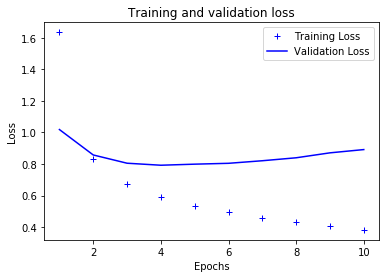

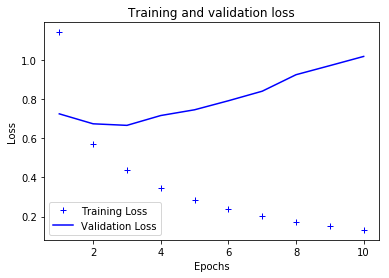

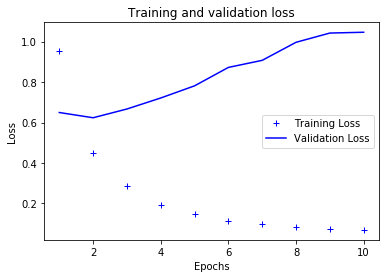

In [50]:
chart_loss(history_small)
chart_loss(history_medium)
chart_loss(history_large)

In [53]:
def chart_acc(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'b+', label='Training Acc')
    plt.plot(epochs, val_acc, 'b', label='Validation Acc')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Accuray')
    plt.legend()
    plt.show()

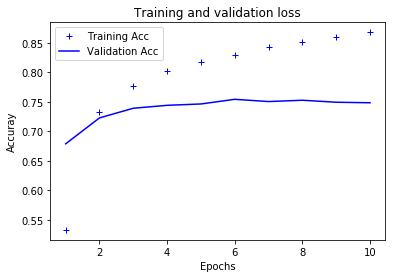

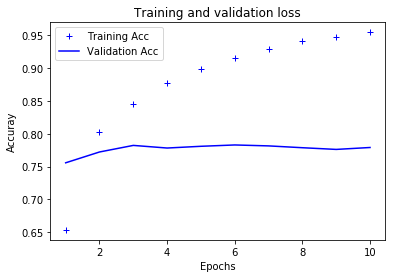

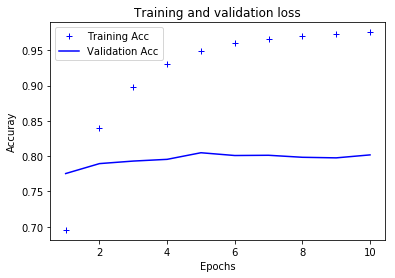

In [54]:
chart_acc(history_small)
chart_acc(history_medium)
chart_acc(history_large)

In [68]:
def compare_loss(histories):
    epochs = range(1, len(histories[0].history['val_loss']) + 1)

    for i, history in enumerate(histories):
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Training Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

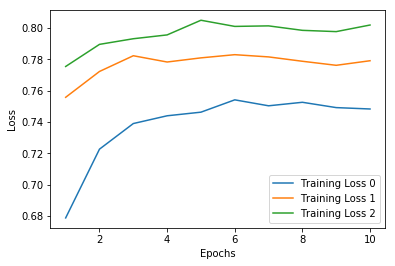

In [69]:
compare_loss([history_small, history_medium, history_large])

In [68]:
def compare_loss(histories):
    epochs = range(1, len(histories[0].history['val_loss']) + 1)

    for i, history in enumerate(histories):
        val_loss = history.history['val_loss']
        plt.plot(epochs, val_loss, label='Training Loss {}'.format(i))
            
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

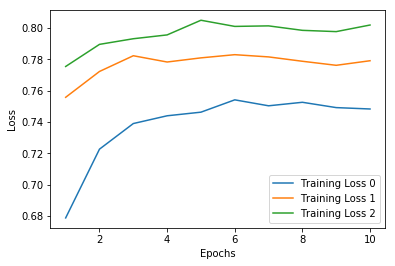

In [69]:
compare_loss([history_small, history_medium, history_large])

### Evaluate on the Test Set

- train the best model for the best epochs

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

In [ ]:
print('loss {}'.format(loss))
print()